# Plot three-panel plot of cloud base height distribution from w-band, SEA-POL echo base height distribution, and spatial map of echo base height

- cloud base  height from cloudnet product
- echo base height from SEA-POL volume level 4v1.2

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import cftime
import json
import glob
import os

import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seaborn as sns

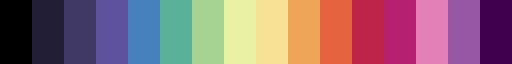

In [2]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='lightgray') #set missing (NaN) values to gray

discrete_mask_cmap

W-band cloud radar

In [3]:
# Read in data
#QmSw6jc9FrcY6tcnKw2bvHJ2NYwS5WwRjSsPxNM4fcVvTr
#wband = xr.open_dataset("ipfs://bafybeiceihwds4qy6nqxfpp7qqot7xjlpjrtv5yq3t6uwnupk3bawhnbte", engine="zarr")
wband = xr.open_dataset("ipns://latest.orcestra-campaign.org/products/METEOR/cloudnet.zarr", engine="zarr")
wband

<xarray.Dataset> Size: 7GB
Dimensions:                 (time: 106200, height: 393)
Coordinates:
  * height                  (height) float32 2kB 120.3 135.3 ... 1.198e+04
  * time                    (time) datetime64[ns] 850kB 2024-08-17T00:00:15 ....
Data variables: (12/55)
    N_scaled                (time, height) float32 167MB ...
    Tw                      (time, height) float32 167MB ...
    Z                       (time, height) float32 167MB ...
    Z_bias                  (time) float32 425kB ...
    Z_error                 (time, height) float32 167MB ...
    Z_sensitivity           (time, height) float32 167MB ...
    ...                      ...
    rain_detected           (time) float64 850kB ...
    rainfall_rate           (time) float32 425kB ...
    target_classification   (time, height) float64 334MB ...
    v                       (time, height) float32 167MB ...
    v_sigma                 (time, height) float32 167MB ...
    width                   (time, height) float32 167MB ...
Attributes: (12/18)
    Conventions:         CF-1.8
    cloudnet_file_type:  der
    title:               Cloud radar and Cloudnet on RV Meteor during BOWTIE
    location:            RV Meteor
    year:                2024
    source:              RPG-Radiometer Physics RPG-FMCW-94\nLufft CHM15k\nEC...
    ...                  ...
    platform:            RV METEOR
    institution:         Leipzig Institute for Meteorology, Leipzig University
    instrument:          Cloudnet product based on cloud radar, ceilometer, m...
    creator_id:          ORCiD: 0000-0002-1164-3576
    keywords:            Cloudnet, effective radius, droplet
    featureType:         trajectoryProfile

SEA-POL data

In [4]:
# read in data
seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4v1.2/PICCOLO_level4_volume_3D.nc')
seapol

<xarray.Dataset> Size: 427GB
Dimensions:       (time: 8708, Z: 19, Y: 241, X: 241)
Coordinates:
  * X             (X) float32 964B -1.2e+05 -1.19e+05 ... 1.19e+05 1.2e+05
  * Y             (Y) float32 964B -1.2e+05 -1.19e+05 ... 1.19e+05 1.2e+05
  * Z             (Z) float32 76B 0.0 1e+03 2e+03 ... 1.6e+04 1.7e+04 1.8e+04
    latitude      (time, Y, X) float32 2GB ...
    longitude     (time, Y, X) float32 2GB ...
  * time          (time) datetime64[ns] 70kB 2024-08-16T08:10:00 ... 2024-09-...
Data variables: (12/15)
    HID_CSU       (time, Z, Y, X) float32 38GB ...
    DBZ           (time, Z, Y, X) float32 38GB ...
    KDP           (time, Z, Y, X) float32 38GB ...
    PHIDP         (time, Z, Y, X) float32 38GB ...
    RAINRATE      (time, Z, Y, X) float32 38GB ...
    RHOHV         (time, Z, Y, X) float32 38GB ...
    ...            ...
    WIDTH         (time, Z, Y, X) float32 38GB ...
    ZDR           (time, Z, Y, X) float32 38GB ...
    grid_mapping  int32 4B ...
    heading       (time) float32 35kB ...
    start_time    (time) datetime64[ns] 70kB ...
    stop_time     (time) datetime64[ns] 70kB ...
Attributes: (12/15)
    Conventions:       CF-1.12
    institution:       Colorado State University
    source:            CSU SEA-POL radar
    instrument:        SEA-POL
    title:             Level 4 Gridded SEA-POL Radar Data
    summary:           Level 4 Gridded SEA-POL Radar Data
    ...                ...
    project:           PICCOLO, BOWTIE, ORCESTRA
    platform:          RV METEOR
    keywords:          radar, precipitation, sea-pol
    processing_level:  Level 4
    license:           CC-BY-4.0
    history:           v1.2

In [6]:
# sea-pol echo base height data
#seapol_echobase_all = xr.open_dataset('../../data/SEA-POL_echo_base_height.nc') #all data within 120 km, all AP times
#seapol_echobase_vol1 = xr.open_dataset('../../data/SEA-POL_echo_base_height_vol1.nc') #all data within 120 km, volume 1 times only (10s)
#seapol_echobase_all_50_120 = xr.open_dataset('../../data/SEA-POL_echo_base_height_50_120.nc') #all data between 50-120 km, all AP times
#seapol_echobase_vol1_50_120 = xr.open_dataset('../../data/SEA-POL_echo_base_height_vol1_50_120.nc') #all data between 50-120 km, volume 1 times only (10s)

seapol_echobase_40 = xr.open_dataset('../../data/SEA-POLv1.0_echo_base_height_vol1_50_120_40dbz.nc') #40 dBZ threshold
seapol_echobase_30 = xr.open_dataset('../../data/SEA-POLv1.0_echo_base_height_vol1_50_120_30dbz.nc') #30 dBZ threshold
seapol_echobase_20 = xr.open_dataset('../../data/SEA-POLv1.0_echo_base_height_vol1_50_120_20dbz.nc') #20 dBZ threshold
seapol_echobase_10 = xr.open_dataset('../../data/SEA-POLv1.0_echo_base_height_vol1_50_120_10dbz.nc') #10 dBZ threshold
seapol_echobase_5 = xr.open_dataset('../../data/SEA-POLv1.0_echo_base_height_vol1_50_120_5dbz.nc') #5 dBZ threshold
seapol_echobase_0 = xr.open_dataset('../../data/SEA-POLv1.0_echo_base_height_vol1_50_120_0dbz.nc') #0 dBZ threshold
seapol_echobase_neg5 = xr.open_dataset('../../data/SEA-POLv1.0_echo_base_height_vol1_50_120_-5dbz.nc') #-5 dBZ threshold
seapol_echobase_neg10 = xr.open_dataset('../../data/SEA-POLv1.0_echo_base_height_vol1_50_120_-10dbz.nc') #-10 dBZ threshold

In [44]:
# sea-pol echo base & top height data
#seapol_echotop = xr.open_dataset('../../data/SEA-POLv1.0_echo_top_height_vol1_50_120.nc')
seapol_echobasetop = xr.open_dataset('../../data/SEA-POLv1.2_echo_base_top_height_vol1_50_120_10dbz.nc')

Calculate percentages of echo base height

In [45]:
#Calculate percentage of echo base heights greater than 0 km
n_echo_0km = np.size(np.where(seapol_echobasetop.echo_base_height.values>0))/(np.size(seapol_echobasetop.echo_base_height.values))
print('Fraction of echo bases > 0 km:', n_echo_0km)

#Calculate percentage of echo base heights greater than 1 km
n_echo_1km = np.size(np.where(seapol_echobasetop.echo_base_height.values>1000))/(np.size(seapol_echobasetop.echo_base_height.values))
print('Fraction of echo bases > 1 km:', n_echo_1km)

#Calculate percentage of echo base heights greater than 2 km
n_echo_2km = np.size(np.where(seapol_echobasetop.echo_base_height.values>2000))/(np.size(seapol_echobasetop.echo_base_height.values))
print('Fraction of echo bases > 2 km:', n_echo_2km)

#Calculate percentage of echo base heights greater than 4 km 
n_echo_4km = np.size(np.where(seapol_echobasetop.echo_base_height.values>4000))/(np.size(seapol_echobasetop.echo_base_height.values))
print('Fraction of echo bases > 4 km:', n_echo_4km)

#Calculate percentage of echo base heights greater than 6 km 
n_echo_6km = np.size(np.where(seapol_echobasetop.echo_base_height.values>6000))/(np.size(seapol_echobasetop.echo_base_height.values))
print('Fraction of echo bases > 6 km:', n_echo_6km)

#Calculate percentage of echo base heights greater than 8 km 
n_echo_8km = np.size(np.where(seapol_echobasetop.echo_base_height.values>8000))/(np.size(seapol_echobasetop.echo_base_height.values))
print('Fraction of echo bases > 8 km:', n_echo_8km)

#Calculate percentage of echo base heights greater than 10 km 
n_echo_10km = np.size(np.where(seapol_echobasetop.echo_base_height.values>10000))/(np.size(seapol_echobasetop.echo_base_height.values))
print('Fraction of echo bases > 10 km:', n_echo_10km)

#Calculate percentage of echo base heights between 2-6 km
n_echo_congestus = np.size(np.where((seapol_echobasetop.echo_base_height.values>2000) & (seapol_echobasetop.echo_base_height.values<6000)))/(np.size(seapol_echobasetop.echo_base_height.values))
print('Fraction of echo bases > 2 km and < 6 km:', n_echo_congestus)

Fraction of echo bases > 0 km: 0.49508172088468155
Fraction of echo bases > 1 km: 0.21705032647362554
Fraction of echo bases > 2 km: 0.1276568424140627
Fraction of echo bases > 4 km: 0.0508554715260969
Fraction of echo bases > 6 km: 0.017992040276192587
Fraction of echo bases > 8 km: 0.004856606936224917
Fraction of echo bases > 10 km: 0.0010225605350404159
Fraction of echo bases > 2 km and < 6 km: 0.096723460220395


Calculate SEA-POL echo base height for one single time to plot as a map

In [104]:
#Define time period for spatial map
time_map = np.datetime64('2024-08-26T01:50')
#time_map = np.datetime64('2024-08-22T01:50') # this is the time with the maximum elevated echofraction > 2 km out of total grid points
#time_map = np.datetime64('2024-08-25T22:50') # this is the time with the maximum elevated echofraction > 4 km out of total grid points
#time_map = np.datetime64('2024-09-02T10:40') # this is the time with the maximum elevated echofraction > 4 km out of total grid points
#time_map = np.datetime64('2024-09-02T22:10') # this is the time with the maximum elevated echofraction > 4 km out of total grid points

index_map = np.abs(pd.to_datetime(seapol.time) - time_map).argmin()
map_dbz = seapol.DBZ[index_map,:,:,:]

# set to nan outside of radius 120 km to only include data with the 3D volume
radius = 120  # km
distances = np.sqrt((map_dbz.latitude - map_dbz.latitude[120, 120])**2 + (map_dbz.longitude - map_dbz.longitude[120, 120])**2) * 111.32  # Approximate conversion from degrees to km
map_dbz = map_dbz.where(distances<=radius,np.nan)  # Set values outside the radius to NaN

# also mask within radius_inner, to limit to radial range where we have "full" 3D coverage
map_dbz2 = map_dbz.where(distances >= 50, np.nan)


In [105]:
#find the minimum height where the reflectivity is above a threshold
threshold = 10

# mask for valid (non-NaN) data
valid_data = ~np.isnan(map_dbz2.values)

# mask for reflectivity above threshold
above_thresh = valid_data & (map_dbz2.values >= threshold)

# Find the lowest index (height) where above_thresh is True for each (y, x), if not found return -1
min_indices = np.where(above_thresh.any(axis=0), np.argmax(above_thresh, axis=0), -1)

# Find the highest index (height) where above_thresh is True for each (y, x), if not found return -1
max_indices = np.where(above_thresh.any(axis=0), above_thresh.shape[0] - 1 - np.argmax(above_thresh[::-1], axis=0), -1)

# Initialize output: NaN where no valid data, -5 where threshold not met
echo_base_height = np.full(map_dbz2.shape[1:], np.nan)
echo_top_height = np.full(map_dbz2.shape[1:], np.nan)
has_valid = valid_data.any(axis=0)
echo_base_height[has_valid] = -5
echo_top_height[has_valid] = -5

# Set echo base height where threshold is met
valid_base = min_indices != -1
echo_base_height[valid_base] = map_dbz2.Z.values[min_indices[valid_base].astype(int)]

# Set echo top height where threshold is met
valid_top = max_indices != -1
echo_top_height[valid_top] = map_dbz2.Z.values[max_indices[valid_top].astype(int)]

# Calculate fraction of echoes in this scene that are elevated
elevated_fraction = len(np.where(echo_base_height[valid_base].flatten()>1000)[0]) / len(echo_base_height[valid_base].flatten()) if len(echo_base_height[valid_base].flatten()) > 0 else np.nan
print('Elevated echo fraction (>1 km):', elevated_fraction)

elevated_fraction = len(np.where(echo_base_height[valid_base].flatten()>2000)[0]) / len(echo_base_height[valid_base].flatten()) if len(echo_base_height[valid_base].flatten()) > 0 else np.nan
print('Elevated echo fraction (>2 km):', elevated_fraction)

elevated_fraction = len(np.where(echo_base_height[valid_base].flatten()>3000)[0]) / len(echo_base_height[valid_base].flatten()) if len(echo_base_height[valid_base].flatten()) > 0 else np.nan
print('Elevated echo fraction (>3 km):', elevated_fraction)

elevated_fraction = len(np.where(echo_base_height[valid_base].flatten()>4000)[0]) / len(echo_base_height[valid_base].flatten()) if len(echo_base_height[valid_base].flatten()) > 0 else np.nan
print('Elevated echo fraction (>4 km):', elevated_fraction)

Elevated echo fraction (>1 km): 1.0
Elevated echo fraction (>2 km): 1.0
Elevated echo fraction (>3 km): 1.0
Elevated echo fraction (>4 km): 0.7563025210084033


Apply rain attenuation flag to w-band data

In [11]:
#exclude data where rain attenuation flag equals 1
wband_cloudbase = wband.cloud_base_height_amsl[wband.rain_attenuation_flag!=1]
wband_cloudtop = wband.cloud_top_height_amsl[wband.rain_attenuation_flag!=1]

## OR ##

#use all data
#wband_cloudbase = wband.cloub_base_height_amsl
#wband_cloudtop = wband.cloud_top_height_amsl

In [12]:
print(np.nanmean(wband_cloudbase.values))
print(np.nanmean(wband.cloud_base_height_amsl.values))

2441.714
2414.8018


Plot 

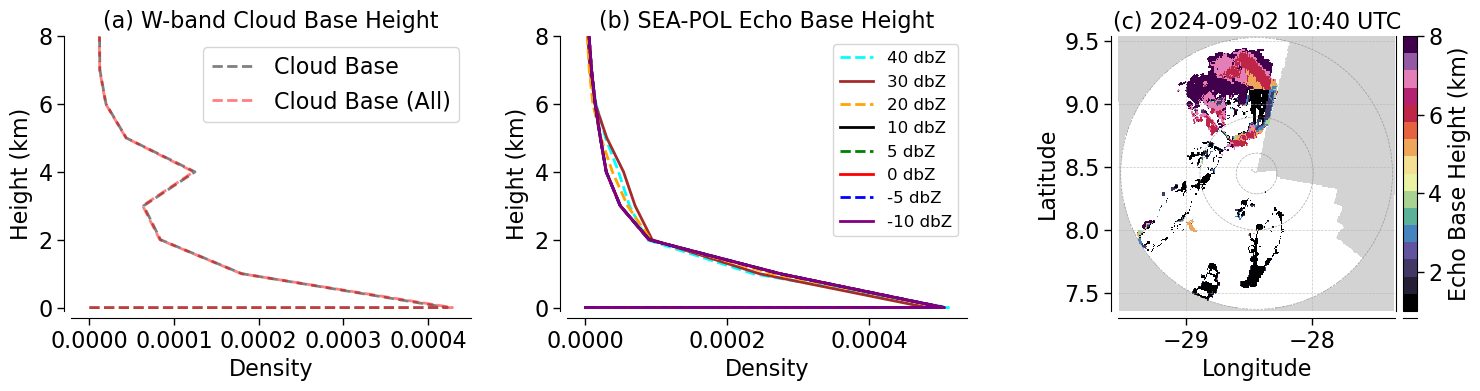

In [13]:
#Plot pdf of wband cloud base and top height
fig, axs = plt.subplots(1,3,figsize=(15,4))

bins =np.concatenate(([-1],np.arange(0, 14000, 1000)))
seapol_bins = np.concatenate(([-1],np.arange(0, 18500, 1000)))
cb_hist, bin_edges_cb = np.histogram(wband_cloudbase, bins=bins, density=True)
cb_hist2, bin_edges_cb2 = np.histogram(wband.cloud_base_height_amsl, bins=bins, density=True)
ct_hist, bin_edges_ct = np.histogram(wband_cloudtop, bins=bins, density=True)
ct_hist2, bin_edges_ct2 = np.histogram(wband.cloud_top_height_amsl, bins=bins, density=True)
eth_hist, bin_edges_eth = np.histogram(seapol_echobase_10.echo_base_height, bins=seapol_bins, density=True)
eth_hist2, bin_edges_eth2 = np.histogram(seapol_echobase_5.echo_base_height, bins=seapol_bins, density=True)
eth_hist3, bin_edges_eth3 = np.histogram(seapol_echobase_0.echo_base_height, bins=seapol_bins, density=True)
eth_hist4, bin_edges_eth4 =  np.histogram(seapol_echobase_neg5.echo_base_height, bins=seapol_bins, density=True)
eth_hist5, bin_edges_eth5 =  np.histogram(seapol_echobase_neg10.echo_base_height, bins=seapol_bins, density=True) 
eth_hist6, bin_edges_eth6 =  np.histogram(seapol_echobase_20.echo_base_height, bins=seapol_bins, density=True)
eth_hist7, bin_edges_eth7 =  np.histogram(seapol_echobase_30.echo_base_height, bins=seapol_bins, density=True)  
eth_hist8, bin_edges_eth8 =  np.histogram(seapol_echobase_40.echo_base_height, bins=seapol_bins, density=True)

#axs[0].plot(ct_hist,bin_edges_ct[:-1]/1000,color='black', linewidth=2,label='Cloud Top')
#axs[0].plot(ct_hist2,bin_edges_ct2[:-1]/1000,color='red', linewidth=2,label='Cloud Top (All)')
axs[0].plot(cb_hist,bin_edges_cb[:-1]/1000,color='gray', linestyle = '--', linewidth=2,label='Cloud Base')
axs[0].plot(cb_hist2,bin_edges_cb2[:-1]/1000,color='red', alpha = 0.5, linestyle = '--', linewidth=2,label='Cloud Base (All)')

#add a horizontal line at 12000
axs[0].axhline(12, color='black', linestyle='--', linewidth=1)

axs[0].set_xlabel('Density',fontsize=16)
axs[0].set_ylabel('Height (km)',fontsize=16)
axs[0].set_ylim([-0.1,8])
axs[0].tick_params(axis='both', labelsize=16)
axs[0].legend(fontsize=16)
axs[0].set_title('(a) W-band Cloud Base Height', fontsize=16)

axs[1].plot(eth_hist8,bin_edges_eth8[:-1]/1000,color='cyan', linestyle='--',linewidth=2,label='40 dbZ')
axs[1].plot(eth_hist7,bin_edges_eth7[:-1]/1000,color='brown', linewidth=2,label='30 dbZ')
axs[1].plot(eth_hist6,bin_edges_eth6[:-1]/1000,color='orange', linestyle='--', linewidth=2,label='20 dbZ')
axs[1].plot(eth_hist,bin_edges_eth[:-1]/1000,color='black', linewidth=2,label='10 dbZ')
axs[1].plot(eth_hist2,bin_edges_eth2[:-1]/1000,color='green', linestyle='--', linewidth=2,label='5 dbZ')
axs[1].plot(eth_hist3,bin_edges_eth3[:-1]/1000,color='red', linewidth=2,label='0 dbZ')
axs[1].plot(eth_hist4,bin_edges_eth4[:-1]/1000,color='blue', linestyle='--',linewidth=2,label='-5 dbZ')
axs[1].plot(eth_hist5,bin_edges_eth5[:-1]/1000,color='purple', linewidth=2,label='-10 dbZ')

axs[1].set_xlabel('Density',fontsize=16)
axs[1].set_ylabel('Height (km)',fontsize=16)
axs[1].set_ylim([-.1,8])
axs[1].tick_params(axis='both', labelsize=16)
axs[1].legend(fontsize=12)
axs[1].set_title('(b) SEA-POL Echo Base Height', fontsize=16)

cax = axs[2].pcolormesh(map_dbz.longitude, map_dbz.latitude, echo_base_height/1000, cmap=discrete_mask_cmap, vmin=1, vmax=8)
axs[2].set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs[2], orientation='vertical',pad=0.02)
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('Echo Base Height (km)', fontsize=16)
dt_str = pd.to_datetime(seapol.time[index_map].values).strftime('%Y-%m-%d %H:%M')
axs[2].set_title('(c) ' + dt_str + ' UTC',fontsize=16)
axs[2].tick_params(axis='both', labelsize=16)
axs[2].set_xlabel('Longitude', fontsize=16)
axs[2].set_ylabel('Latitude', fontsize=16)

# Add grid lines 
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Add 120 km circle
axs[2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 50 km circle
axs[2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 50/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 18 km circle
axs[2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 18/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout() 

#plt.savefig('../Plots/Fig_echo_base_top.pdf', bbox_inches='tight', dpi=300)

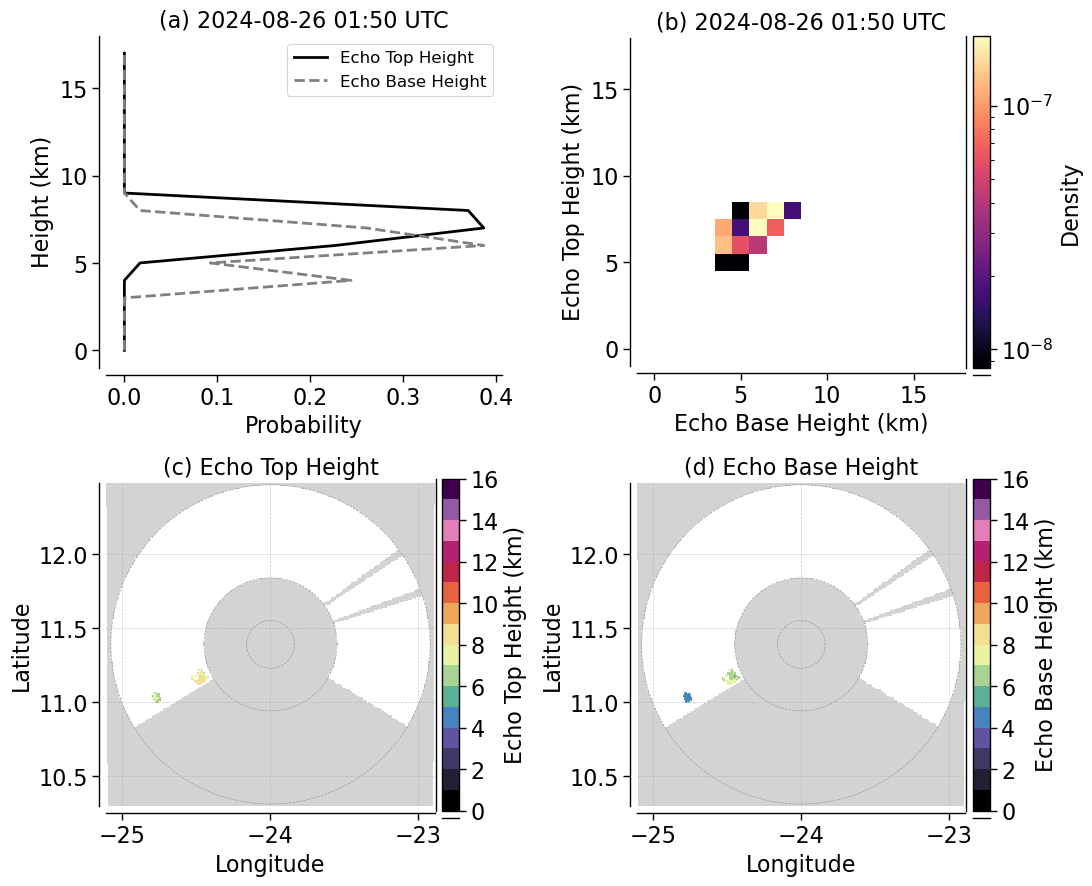

In [106]:
#Plot specific scene
fig, axs = plt.subplots(2,2,figsize=(11,9))

seapol_bins = np.concatenate(([-1],np.arange(0, 18500, 1000)))

#############PDF OF ECHO BASE HEIGHT AND ECHO TOP HEIGHT ##############
ebh_hist, bin_edges_ebh = np.histogram(echo_base_height[valid_base].flatten(), bins=seapol_bins, density=True)
eth_hist, bin_edges_eth = np.histogram(echo_top_height[valid_top].flatten(), bins=seapol_bins, density=True)

axs[0,0].plot(eth_hist*np.diff(bin_edges_eth),bin_edges_eth[:-1]/1000,color='black', linewidth=2,label='Echo Top Height')
axs[0,0].plot(ebh_hist*np.diff(bin_edges_ebh),bin_edges_ebh[:-1]/1000,color='gray', linestyle = '--', linewidth=2,label='Echo Base Height')

axs[0,0].set_xlabel('Probability',fontsize=16)
axs[0,0].set_ylabel('Height (km)',fontsize=16)
axs[0,0].set_ylim([-1,18])
axs[0,0].tick_params(axis='both', labelsize=16)
axs[0,0].legend(fontsize=12)
dt_str = pd.to_datetime(seapol.time[index_map].values).strftime('%Y-%m-%d %H:%M')
axs[0,0].set_title('(a) ' + dt_str + ' UTC',fontsize=16)

###############2D HISTOGRAM OF ECHO BASE HEIGHT VS ECHO TOP HEIGHT ##############
ebh_eth_2dhist, ebh_edges, eth_edges = np.histogram2d(echo_base_height[valid_base].flatten(), echo_top_height[valid_top].flatten(), bins=[seapol_bins, seapol_bins], density=True)
bin_areas = np.diff(ebh_edges)[:, None] * np.diff(eth_edges)[None, :]
ebh_eth_prob = ebh_eth_2dhist * bin_areas  # Convert density to probability

#create a copy of the colorbar and set Nan values to white
magma_white = plt.cm.magma.copy()
magma_white.set_bad(color='white')

# set zero values to NaN
ebh_eth_2dhist[ebh_eth_2dhist==0] = np.nan

X, Y = np.meshgrid(np.concatenate(([-1], ebh_edges[1:-1]/1000)), np.concatenate(([-1], eth_edges[1:-1]/1000)))
cax = axs[0,1].pcolormesh(X, Y, ebh_eth_2dhist.T, shading='nearest', cmap=magma_white, norm=colors.LogNorm(vmin=np.nanmin(ebh_eth_2dhist), vmax=np.nanmax(ebh_eth_2dhist)))
cbar = fig.colorbar(cax, ax=axs[0,1], orientation='vertical',pad=0.02)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('Density', fontsize=16)
axs[0,1].set_xlim([-1,18])
axs[0,1].set_ylim([-1,18])
axs[0,1].set_xlabel('Echo Base Height (km)', fontsize=16)
axs[0,1].set_ylabel('Echo Top Height (km)', fontsize=16)
dt_str = pd.to_datetime(seapol.time[index_map].values).strftime('%Y-%m-%d %H:%M')
axs[0,1].set_title('(b) ' + dt_str + ' UTC',fontsize=16)
axs[0,1].tick_params(axis='both', labelsize=16)
axs[0,1].set_aspect('equal', adjustable='box')

#############SPATIAL MAP OF ECHO TOP HEIGHT ##############
cax = axs[1,0].pcolormesh(map_dbz.longitude, map_dbz.latitude, echo_top_height/1000, cmap=discrete_mask_cmap, vmin=0, vmax=16)
axs[1,0].set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs[1,0], orientation='vertical',pad=0.02)
cbar.ax.tick_params(labelsize=16)
cbar.set_ticks(np.arange(0,17,2))
cbar.set_ticklabels(np.arange(0,17,2))
cbar.ax.set_ylabel('Echo Top Height (km)', fontsize=16)
axs[1,0].set_title('(c) Echo Top Height',fontsize=16)
axs[1,0].tick_params(axis='both', labelsize=16)
axs[1,0].set_xlabel('Longitude', fontsize=16)
axs[1,0].set_ylabel('Latitude', fontsize=16)

# Add grid lines 
axs[1,0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Add 120 km circle
axs[1,0].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 50 km circle
axs[1,0].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 50/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 18 km circle
axs[1,0].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 18/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

##############SPATIAL MAP OF ECHO BASE HEIGHT ##############
cax = axs[1,1].pcolormesh(map_dbz.longitude, map_dbz.latitude, echo_base_height/1000, cmap=discrete_mask_cmap, vmin=0, vmax=16)
axs[1,1].set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs[1,1], orientation='vertical',pad=0.02)
cbar.ax.tick_params(labelsize=16)
cbar.set_ticks(np.arange(0,17,2))
cbar.set_ticklabels(np.arange(0,17,2))
cbar.ax.set_ylabel('Echo Base Height (km)', fontsize=16)
axs[1,1].set_title('(d) Echo Base Height',fontsize=16)
axs[1,1].tick_params(axis='both', labelsize=16)
axs[1,1].set_xlabel('Longitude', fontsize=16)
axs[1,1].set_ylabel('Latitude', fontsize=16)

# Add grid lines 
axs[1,1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Add 120 km circle
axs[1,1].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 50 km circle
axs[1,1].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 50/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 18 km circle
axs[1,1].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 18/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout() 

#plt.savefig('../Plots/Fig_echo_base_top.pdf', bbox_inches='tight', dpi=300)

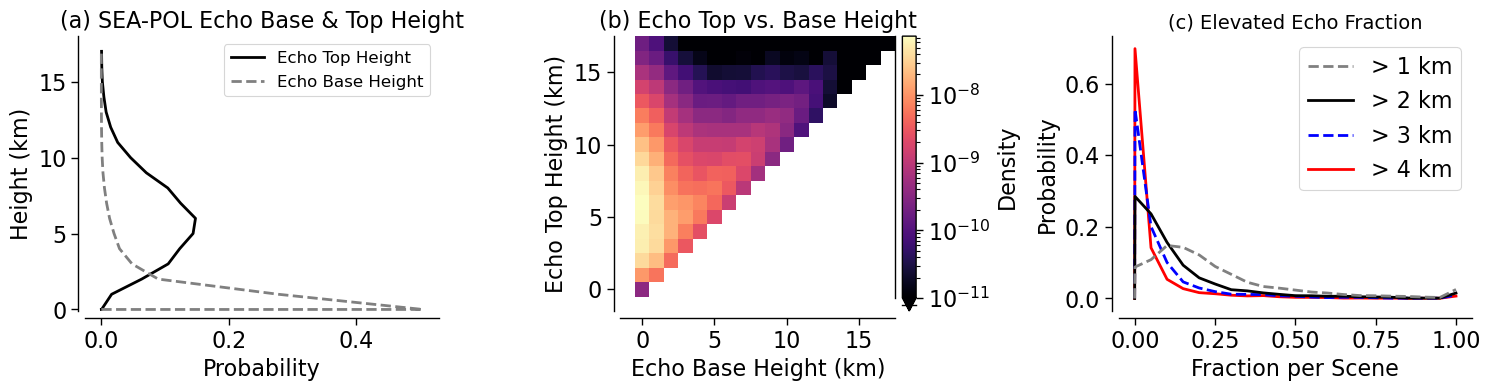

In [87]:
#Plot pdf of sea-pol echo base and top height over whole campaign
fig, axs = plt.subplots(1,3,figsize=(15,4))

seapol_bins = np.concatenate(([-1],np.arange(0, 18500, 1000)))

###################### OVERALL PDF OF ECHO BASE HEIGHT AND ECHO TOP HEIGHT #######################
ebh_hist, bin_edges_ebh = np.histogram(seapol_echobasetop.echo_base_height, bins=seapol_bins, density=True)
eth_hist, bin_edges_eth = np.histogram(seapol_echobasetop.echo_top_height, bins=seapol_bins, density=True)

axs[0].plot(eth_hist*np.diff(bin_edges_eth),bin_edges_eth[:-1]/1000,color='black', linewidth=2,label='Echo Top Height')
axs[0].plot(ebh_hist*np.diff(bin_edges_ebh),bin_edges_ebh[:-1]/1000,color='gray', linestyle = '--', linewidth=2,label='Echo Base Height')

axs[0].set_xlabel('Probability',fontsize=16)
axs[0].set_ylabel('Height (km)',fontsize=16)
axs[0].set_ylim([-.1,18])
axs[0].tick_params(axis='both', labelsize=16)
axs[0].legend(fontsize=12)
axs[0].set_title('(a) SEA-POL Echo Base & Top Height', fontsize=16)

####################### 2D HISTOGRAM OF ECHO BASE HEIGHT VS ECHO TOP HEIGHT #######################
ebh_eth_2dhist, ebh_edges, eth_edges = np.histogram2d(seapol_echobasetop.echo_base_height.values.flatten(), seapol_echobasetop.echo_top_height.values.flatten(), bins=[seapol_bins, seapol_bins], density=True)
bin_areas = np.diff(ebh_edges)[:, None] * np.diff(eth_edges)[None, :]
ebh_eth_prob = ebh_eth_2dhist * bin_areas  # Convert density to probability

#create a copy of the colorbar and set Nan values to white
magma_white = plt.cm.magma.copy()
magma_white.set_bad(color='white')

# set zero values to NaN
ebh_eth_2dhist[ebh_eth_2dhist==0] = np.nan

X, Y = np.meshgrid(np.concatenate(([-1], ebh_edges[1:-1]/1000)), np.concatenate(([-1], eth_edges[1:-1]/1000)))
cax = axs[1].pcolormesh(X, Y, ebh_eth_2dhist.T, shading='nearest', cmap=magma_white, norm=colors.LogNorm(vmin=1e-11, vmax=np.nanmax(ebh_eth_2dhist)))
cbar = fig.colorbar(cax, ax=axs[1], orientation='vertical',pad=0.02,extend='min')
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('Density', fontsize=16)
axs[1].set_xlabel('Echo Base Height (km)', fontsize=16)
axs[1].set_ylabel('Echo Top Height (km)', fontsize=16)
axs[1].set_title('(b) Echo Top vs. Base Height',fontsize=16)
axs[1].tick_params(axis='both', labelsize=16)
axs[1].set_aspect('equal', adjustable='box')

###################### PDF OF ELEVATED ECHO FRACTION #######################
echo_frac_bins = np.concatenate(([-0.001],np.arange(0,1.06,0.05)))
echo_frac_hist1, bin_edges_ef = np.histogram(seapol_echobasetop.elevated_echo_fraction1, bins=echo_frac_bins, density=True)
echo_frac_hist2, bin_edges_ef2 = np.histogram(seapol_echobasetop.elevated_echo_fraction2, bins=echo_frac_bins, density=True)
echo_frac_hist3, bin_edges_ef3 = np.histogram(seapol_echobasetop.elevated_echo_fraction3, bins=echo_frac_bins, density=True)
echo_frac_hist4, bin_edges_ef4 = np.histogram(seapol_echobasetop.elevated_echo_fraction4, bins=echo_frac_bins, density=True)

axs[2].plot(bin_edges_ef[:-1],echo_frac_hist1*np.diff(bin_edges_ef),color='gray', linestyle='--', linewidth=2, label='> 1 km',zorder=3)
axs[2].plot(bin_edges_ef[:-1],echo_frac_hist2*np.diff(bin_edges_ef2),color='black', linewidth=2, label='> 2 km', zorder=2)
axs[2].plot(bin_edges_ef[:-1],echo_frac_hist3*np.diff(bin_edges_ef3),color='blue', linestyle='--', linewidth=2, label='> 3 km', zorder=1)
axs[2].plot(bin_edges_ef[:-1],echo_frac_hist4*np.diff(bin_edges_ef4),color='red', linewidth=2, label='> 4 km', zorder=0)
axs[2].set_xlabel('Fraction per Scene',fontsize=16)
axs[2].set_ylabel('Probability',fontsize=16)
axs[2].tick_params(axis='both', labelsize=16)
axs[2].set_title('(c) Elevated Echo Fraction', fontsize=14)
#axs[2].set_ylim([-0.001,0.2])

plt.legend(fontsize=16)

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout() 

#plt.savefig('../Plots/Fig_echo_base_top.pdf', bbox_inches='tight', dpi=300)

In [93]:
print('Mean Elevated Echo Fraction > 1 km:', np.nanmean(seapol_echobasetop.elevated_echo_fraction1.values))
print('Mean Elevated Echo Fraction > 2 km:', np.nanmean(seapol_echobasetop.elevated_echo_fraction2.values))
print('Mean Elevated Echo Fraction > 3 km:', np.nanmean(seapol_echobasetop.elevated_echo_fraction3.values))
print('Mean Elevated Echo Fraction > 4 km:', np.nanmean(seapol_echobasetop.elevated_echo_fraction4.values))

Mean Elevated Echo Fraction > 1 km: 0.26483281920536195
Mean Elevated Echo Fraction > 2 km: 0.15450643144038426
Mean Elevated Echo Fraction > 3 km: 0.09789353930230392
Mean Elevated Echo Fraction > 4 km: 0.06553735192036012


In [137]:
# find when elevated echo fraction above 0.75 for > 4 km
high_elevated_times = seapol_echobasetop.time.values[(seapol_echobasetop.elevated_echo_fraction4.values > 0.75)]
print('Times with Elevated Echo Fraction above 0.75 for > 4 km:', high_elevated_times)
print('Elevated Echo Fractions at those times:', seapol_echobasetop.elevated_echo_fraction4.values[(seapol_echobasetop.elevated_echo_fraction4.values > 0.75)])

Times with Elevated Echo Fraction above 0.75 for > 4 km: ['2024-08-16T09:00:00.000000000' '2024-08-18T16:40:00.000000000'
 '2024-08-18T19:10:00.000000000' '2024-08-19T15:10:00.000000000'
 '2024-08-19T15:20:00.000000000' '2024-08-22T21:10:00.000000000'
 '2024-08-22T21:30:00.000000000' '2024-08-22T22:30:00.000000000'
 '2024-08-22T22:40:00.000000000' '2024-08-23T00:10:00.000000000'
 '2024-08-23T00:30:00.000000000' '2024-08-23T00:40:00.000000000'
 '2024-08-23T05:50:00.000000000' '2024-08-26T01:50:00.000000000'
 '2024-08-26T02:00:00.000000000' '2024-08-26T02:30:00.000000000'
 '2024-08-26T02:40:00.000000000' '2024-08-26T03:50:00.000000000'
 '2024-08-26T20:20:00.000000000' '2024-08-26T22:00:00.000000000'
 '2024-08-26T22:20:00.000000000' '2024-08-26T22:30:00.000000000'
 '2024-08-26T22:40:00.000000000' '2024-08-26T22:50:00.000000000'
 '2024-08-28T05:50:00.000000000' '2024-08-29T22:10:00.000000000'
 '2024-08-30T01:50:00.000000000' '2024-08-30T02:40:00.000000000'
 '2024-09-15T16:40:00.000000000' 

It seems like the scenes with very high elevated fraction (out of valid echoes) are the ones with very few valid echoes. Let's compare elevated echo fraction to low-level precip fractional area coverage

In [125]:
# load data
rain = xr.open_dataset('../../data/SEA-POL_4v1.2_rainrate_2D_spatial_means_reg10.nc')
fa120 = rain.rain120_frac #fractional area of low-level rain coverage within 120 km

In [120]:
#extract fractional area data corresponding to high_elevated_times
high_elevated_times = seapol_echobasetop.time.values[(seapol_echobasetop.elevated_echo_fraction4.values > 0.05)]
fa120_high_elevated = fa120.sel(time=high_elevated_times)
print('Average Fractional Area when Elevated Echo Fraction > 0.05 for > 4 km:', np.nanmean(fa120_high_elevated.values))

high_elevated_times = seapol_echobasetop.time.values[(seapol_echobasetop.elevated_echo_fraction4.values > 0.10)]
fa120_high_elevated = fa120.sel(time=high_elevated_times)
print('Average Fractional Area when Elevated Echo Fraction > 0.10 for > 4 km:', np.nanmean(fa120_high_elevated.values))

high_elevated_times = seapol_echobasetop.time.values[(seapol_echobasetop.elevated_echo_fraction4.values > 0.20)]
fa120_high_elevated = fa120.sel(time=high_elevated_times)
print('Average Fractional Area when Elevated Echo Fraction > 0.20 for > 4 km:', np.nanmean(fa120_high_elevated.values))

high_elevated_times = seapol_echobasetop.time.values[(seapol_echobasetop.elevated_echo_fraction4.values > 0.30)]
fa120_high_elevated = fa120.sel(time=high_elevated_times)
print('Average Fractional Area when Elevated Echo Fraction > 0.30 for > 4 km:', np.nanmean(fa120_high_elevated.values))

high_elevated_times = seapol_echobasetop.time.values[(seapol_echobasetop.elevated_echo_fraction4.values > 0.40)]
fa120_high_elevated = fa120.sel(time=high_elevated_times)
print('Average Fractional Area when Elevated Echo Fraction > 0.40 for > 4 km:', np.nanmean(fa120_high_elevated.values))

high_elevated_times = seapol_echobasetop.time.values[(seapol_echobasetop.elevated_echo_fraction4.values > 0.50)]
fa120_high_elevated = fa120.sel(time=high_elevated_times)
print('Average Fractional Area when Elevated Echo Fraction > 0.50 for > 4 km:', np.nanmean(fa120_high_elevated.values))

high_elevated_times = seapol_echobasetop.time.values[(seapol_echobasetop.elevated_echo_fraction4.values > 0.60)]
fa120_high_elevated = fa120.sel(time=high_elevated_times)
print('Average Fractional Area when Elevated Echo Fraction > 0.60 for > 4 km:', np.nanmean(fa120_high_elevated.values))

high_elevated_times = seapol_echobasetop.time.values[(seapol_echobasetop.elevated_echo_fraction4.values > 0.70)]
fa120_high_elevated = fa120.sel(time=high_elevated_times)
print('Average Fractional Area when Elevated Echo Fraction > 0.70 for > 4 km:', np.nanmean(fa120_high_elevated.values))

high_elevated_times = seapol_echobasetop.time.values[(seapol_echobasetop.elevated_echo_fraction4.values > 0.80)]
fa120_high_elevated = fa120.sel(time=high_elevated_times)
print('Average Fractional Area when Elevated Echo Fraction > 0.80 for > 4 km:', np.nanmean(fa120_high_elevated.values))

high_elevated_times = seapol_echobasetop.time.values[(seapol_echobasetop.elevated_echo_fraction4.values > 0.90)]
fa120_high_elevated = fa120.sel(time=high_elevated_times)
print('Average Fractional Area when Elevated Echo Fraction > 0.90 for > 4 km:', np.nanmean(fa120_high_elevated.values))

Average Fractional Area when Elevated Echo Fraction > 0.05 for > 4 km: 0.05450864493995847
Average Fractional Area when Elevated Echo Fraction > 0.10 for > 4 km: 0.03170216152000212
Average Fractional Area when Elevated Echo Fraction > 0.20 for > 4 km: 0.01594925662164842
Average Fractional Area when Elevated Echo Fraction > 0.30 for > 4 km: 0.01312599110991843
Average Fractional Area when Elevated Echo Fraction > 0.40 for > 4 km: 0.011267155236860626
Average Fractional Area when Elevated Echo Fraction > 0.50 for > 4 km: 0.007062188105721683
Average Fractional Area when Elevated Echo Fraction > 0.60 for > 4 km: 0.005173071105131503
Average Fractional Area when Elevated Echo Fraction > 0.70 for > 4 km: 0.002170358702046881
Average Fractional Area when Elevated Echo Fraction > 0.80 for > 4 km: 0.0015595701752524442
Average Fractional Area when Elevated Echo Fraction > 0.90 for > 4 km: 0.0014090294216325104


Correlation coefficient between Elevated Echo Fraction > 4 km and Fractional Area Coverage within 120 km: -0.12075331791053966


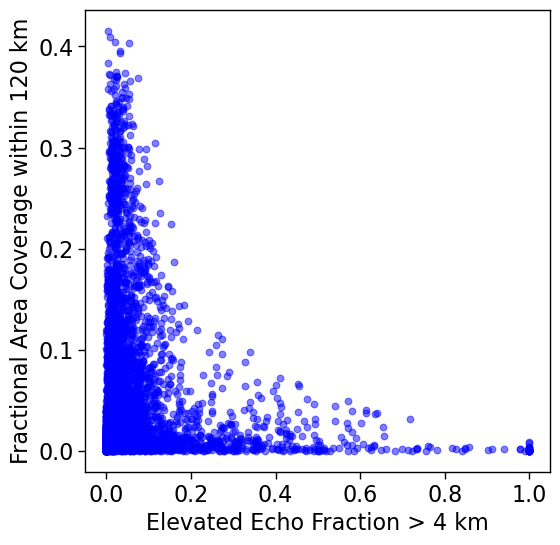

In [134]:
# Make a scatter plot of elevated echo fraction > 4 km vs fractional area of low-level rain coverage within 120 km
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(seapol_echobasetop.elevated_echo_fraction4, fa120[1:], color='blue', alpha=0.5)
ax.set_xlabel('Elevated Echo Fraction > 4 km', fontsize=16)
ax.set_ylabel('Fractional Area Coverage within 120 km', fontsize=16)
ax.tick_params(axis='both', labelsize=16)

#calculate the correlation coefficient, excluding NaN values in both arrays
valid_mask = ~np.isnan(seapol_echobasetop.elevated_echo_fraction4.values) & ~np.isnan(fa120[1:].values)
correlation = np.corrcoef(seapol_echobasetop.elevated_echo_fraction4.values[valid_mask], fa120[1:].values[valid_mask])[0,1]
print('Correlation coefficient between Elevated Echo Fraction > 4 km and Fractional Area Coverage within 120 km:', correlation)

Let's flip things around. What are the elevated echo fractions when the fractional area is above average?